In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [133]:
trades

,symbol,buy_exchange,sell_exchange,profit_percent,profit_abs,running_balance,timestamp
0,None,None,NaN,None,NaN,1000,2024-09-07 01:18:36.722214


In [ ]:
import asyncio

import nest_asyncio
import websockets
import json
import pandas as pd
import itertools
import gzip
import json
from datetime import datetime, timedelta
from colorama import Fore, Back, Style

# Define the exchanges and tickers
exchanges = ['Bybit', 'Binance', 'Huobi', 'OKX']
tickers = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'DOGEUSDT']

# Create an initial DataFrame with all combinations of exchanges and tickers
price_data = pd.DataFrame([
    {'exchange': exchange, 'symbol': ticker, 'bid': None, 'ask': None, 'timestamp': None}
    for exchange in exchanges for ticker in tickers
])

trades = pd.DataFrame(columns=['symbol', 'buy_exchange', 'sell_exchange', 'profit_percent', 'profit_abs', 'running_balance', 'timestamp'])
new_row = {'buy_exchange': None, 'symbol': None, 'profit_percent': None, 'running_balance': 1000, 'timestamp': pd.Timestamp.now()}
trades.loc[len(trades)] = new_row


# Dictionary to store last trade time for each symbol and exchange pair
last_trade_time = {}

# Cooldown period (5 seconds)
cooldown_period = timedelta(seconds=5)

async def handle_huobi_message(message):
    """Handle Huobi ticker stream"""
    decompressed_message = gzip.decompress(message).decode('utf-8')
    data = json.loads(decompressed_message)
    
    # Print the message for debugging
    #print(data)

    if 'ping' in data:
        # Respond to ping to keep connection alive
        pong = json.dumps({'pong': data['ping']})
        return pong
    
    if 'tick' in data:
        symbol = data['ch'].split('.')[1].upper()  # Extract the symbol (e.g., BTCUSDT, ETHUSDT)
        
        # Extract bid and ask prices and quantities
        bids = data['tick']['bids']
        asks = data['tick']['asks']
        
        if bids:
            bid_price = float(bids[0][0])
        else:
            bid_price = None

        if asks:
            ask_price = float(asks[0][0])
        else:
            ask_price = None
        
        timestamp = pd.Timestamp.now()  ################# Very WRONG !!!!!!!!!!!!!!
        
        # Add Huobi data to DataFrame
        new_row = {
            'exchange': 'Huobi',
            'symbol': symbol,
            'bid': bid_price,
            'ask': ask_price,
            'timestamp': timestamp
        }
        
        update_price_data(new_row)

async def subscribe_huobi():
    huobi_url = "wss://api.huobi.pro/ws"
    
    while True:
        try:
            async with websockets.connect(huobi_url, ping_interval=20, ping_timeout=30) as ws:
                print("Connected to Huobi WebSocket")

                subscribe_message = json.dumps({
                    "sub": "market.btcusdt.depth.step0",
                    "id": "BTCUSDT"
                })
                await ws.send(subscribe_message)
                
                subscribe_message_eth = json.dumps({
                    "sub": "market.ethusdt.depth.step0",
                    "id": "ETHUSDT"
                })
                await ws.send(subscribe_message_eth)
                
                subscribe_message_sol = json.dumps({
                    "sub": "market.solusdt.depth.step0",
                    "id": "SOLUSDT"
                })
                await ws.send(subscribe_message_sol)
                
                subscribe_message_doge = json.dumps({
                    "sub": "market.dogeusdt.depth.step0",
                    "id": "DOGEUSDT"
                })
                await ws.send(subscribe_message_sol)
            

                while True:
                    try:
                        message = await ws.recv()
                #        print("Received message:", gzip.decompress(message))  # Debugging print
                        pong = await handle_huobi_message(message)
                        if pong:
                            await ws.send(pong)
                    except websockets.ConnectionClosedError:
                        print("Huobi connection closed, reconnecting...")
                        break  # Reconnect to Huobi WebSocket
                    except Exception as e:
                        print(f"Error receiving message from Huobi: {e}")
        except Exception as e:
            print(f"Failed to connect to Huobi WebSocket: {e}")
            await asyncio.sleep(5)  # Wait before attempting to reconnect

async def handle_binance_message(message):
 #   print(message)
    
    
    """Handle Binance ticker stream"""
    data = json.loads(message)['data']
    symbol = data['s']

    bid_price = float(data['b'])
    ask_price = float(data['a'])
    timestamp = pd.to_datetime(data['E'], unit='ms')

    # Add Binance data to DataFrame
    new_row = {
        'exchange': 'Binance',
        'symbol': symbol,
        'bid': bid_price,
        'ask': ask_price,
        'timestamp': timestamp
    }

    update_price_data(new_row)

async def handle_bybit_message(message):
    """Handle Bybit orderbook stream"""
    data = json.loads(message)
    
    
    if not 'topic' in data:
        return
    
    if data['topic'].startswith('orderbook'):
        symbol = data['data']['s']
        bid_price = float(list(data['data']['b'][0])[0]) if data['data']['b'] else None
        ask_price = float(list(data['data']['a'][0])[0]) if data['data']['a'] else None
        timestamp = pd.to_datetime(data['ts'], unit='ms')
        
        if bid_price is None or ask_price is None:
            return
        
        # Add Bybit data to DataFrame
        new_row = {
            'exchange': 'Bybit',
            'symbol': symbol,
            'bid': bid_price,
            'ask': ask_price,
            'timestamp': timestamp
        }
        
        update_price_data(new_row)

def update_price_data(new_row):
    """Update price data and check for arbitrage opportunities."""
   # if new_row['exchange'] == 'Bybit':
     #   print(f"Exchange: {new_row['exchange']} | Symbol  {new_row['symbol']} |  bid:  {new_row['bid']} | ask:  {new_row['ask']}")
     #   print(new_row)
        
    global price_data
    
    price_data.loc[(price_data['exchange'] == new_row['exchange'])  & (price_data['symbol'] == new_row['symbol']) , ['bid', 'ask', 'timestamp']] =  [ new_row['bid'], new_row['ask'], new_row['timestamp']]
    
    # Check for arbitrage
    check_arbitrage_opportunity2()

async def handle_okx_message(message):
    """Handle OKX order book stream"""
    data = json.loads(message)

    # Ensure the message contains the expected data structure
    if 'arg' in data and 'data' in data:
        symbol = data['arg']['instId']  # The instrument symbol, e.g., ETH-USDT
        book_data = data['data'][0]  # Access the first item in the 'data' array

        # Extract the best bid and ask prices from the order book
        best_bid = float(book_data['bids'][0][0]) if book_data['bids'] else None
        best_ask = float(book_data['asks'][0][0]) if book_data['asks'] else None
        timestamp = pd.Timestamp.now()

        if best_bid is not None and best_ask is not None:
            # Add OKX data to DataFrame
            new_row = {
                'exchange': 'OKX',
                'symbol': symbol.replace('-', ''),  # Remove dash from symbol (ETH-USDT -> ETHUSDT)
                'bid': best_bid,
                'ask': best_ask,
                'timestamp': timestamp
            }
            
            update_price_data(new_row)

async def subscribe_okx():
    okx_url = "wss://ws.okx.com:8443/ws/v5/public"
    
    while True:
        try:
            async with websockets.connect(okx_url, ping_interval=20, ping_timeout=30) as ws:
                print("Connected to OKX WebSocket")

                subscribe_message = json.dumps({
                    "op": "subscribe",
                    "args": [{"channel": "books", "instId": "BTC-USDT"}, {"channel": "books", "instId": "ETH-USDT"}, {"channel": "books", "instId": "DOGE-USDT"}, {"channel": "books", "instId": "SOL-USDT"}]
                })
                await ws.send(subscribe_message)

                while True:
                    try:
                        message = await ws.recv()
                        await handle_okx_message(message)
                    except websockets.ConnectionClosedError:
                        print("OKX connection closed, reconnecting...")
                        break  # Reconnect to OKX WebSocket
                    except Exception as e:
                        print(f"Error receiving message from OKX: {e}")
        except Exception as e:
            print(f"Failed to connect to OKX WebSocket: {e}")
            await asyncio.sleep(5)  # Wait before attempting to reconnect
            
def check_arbitrage_opportunity2():
    """Generalized arbitrage detection logic across multiple exchanges."""
    grouped = price_data.groupby('symbol')  # Group by symbol to handle each symbol independently
    
    for symbol, group in grouped:
        # Check if there are any valid (non-NaN) ask values and find the best (lowest) ask
        if group['ask'].notna().any():
            best_ask = group.loc[group['ask'].idxmin()]  # Exchange with the lowest ask
        else:
           # print(f"No valid ask prices available for {symbol}")
            continue  # Skip to the next symbol if no valid ask prices are available

        # Check if there are any valid (non-NaN) bid values and find the best (highest) bid
        if group['bid'].notna().any():
            best_bid = group.loc[group['bid'].idxmax()]  # Exchange with the highest bid
        else:
        #    print(f"No valid bid prices available for {symbol}")
            continue  # Skip to the next symbol if no valid bid prices are available

        # Ensure both best_ask and best_bid exist and then check arbitrage opportunity
        if best_bid['bid'] > best_ask['ask']:
            profit_percentage = ((best_bid['bid'] - best_ask['ask']) / best_ask['ask'])
            
            if profit_percentage > 0.0021:  # Set a threshold to filter out minor opportunities
                global trades
                now = pd.Timestamp.now()

                # Check if cooldown has passed for this symbol and exchange pair
                pair_key = (symbol, best_bid['exchange'], best_ask['exchange'])
                if pair_key in last_trade_time:
                    time_since_last_trade = now - last_trade_time[pair_key]
                    if time_since_last_trade < cooldown_period:
                        continue  # Skip if still in cooldown period

                real_percentage = profit_percentage - 0.0021  # Deduct estimated trading fees
                # Calculate absolute profit based on running balance
                profit_abs = trades.iloc[-1]['running_balance'] * (real_percentage)
                running_balance = trades.iloc[-1]['running_balance'] + profit_abs

                print(Fore.GREEN + f"Arbitrage opportunity for {symbol}: Buy from {best_ask['exchange']} at {best_ask['ask']}, sell on {best_bid['exchange']} at {best_bid['bid']}  |  Profit: {(real_percentage*100):.6f}% | Balance: {running_balance}")

                new_row = {
                    'buy_exchange': best_ask['exchange'],
                    'sell_exchange': best_bid['exchange'],
                    'symbol': symbol,
                    'profit_percent': real_percentage,
                    'profit_abs': profit_abs,
                    'running_balance': running_balance,
                    'timestamp': now
                }
                trades.loc[len(trades)] = new_row

                # Update last trade time for this symbol and exchange pair
                last_trade_time[pair_key] = now
                
            #else:
            #    print(f"{profit_percentage} isn't worth it")
                

def check_arbitrage_opportunity():
    """Generalized arbitrage detection logic across multiple exchanges."""
    grouped = price_data.groupby('symbol')  # Group by symbol to handle each symbol independently
    
    for symbol, group in grouped:
        # Get all combinations of exchanges (pairs) to compare for each symbol
        exchanges = group['exchange'].unique()
        exchange_pairs = list(itertools.permutations(exchanges, 2))  # All order pairs of exchanges
        
        for exchange_pair in exchange_pairs:
            # Extract data for the two exchanges in the pair
            first_exchange_data = group[group['exchange'] == exchange_pair[0]]
            second_exchange_data = group[group['exchange'] == exchange_pair[1]]
            
            if not first_exchange_data.empty and not second_exchange_data.empty:
                # Get the latest bid from the first exchange and the latest ask from the second exchange
                first_exchange_bid = first_exchange_data.iloc[-1]['bid']
                second_exchange_ask = second_exchange_data.iloc[-1]['ask']
                
                if first_exchange_bid is None or second_exchange_ask is None:
                    continue  # Skip if either bid or ask is missing
                
                # Check if arbitrage opportunity exists (buy on second exchange, sell on first)
                if first_exchange_bid > second_exchange_ask:
                    profit_percentage = ((first_exchange_bid - second_exchange_ask) / second_exchange_ask)
                    
                    if profit_percentage > 0.0021:  # Set a threshold to filter out minor opportunities
                        global trades
                        now = pd.Timestamp.now()

                        # Check if cooldown has passed for this symbol and exchange pair
                        pair_key = (symbol, exchange_pair[0], exchange_pair[1])
                        if pair_key in last_trade_time:
                            time_since_last_trade = now - last_trade_time[pair_key]
                            if time_since_last_trade < cooldown_period:
                                continue  # Skip if still in cooldown period
                        
                        real_percentage = profit_percentage - 0.0021  # Deduct estimated trading fees
                        # Calculate absolute profit based on running balance
                        profit_abs = trades.iloc[-1]['running_balance'] * (real_percentage)
                        running_balance = trades.iloc[-1]['running_balance'] + profit_abs
                        
                        print(Fore.GREEN +  f"Arbitrage opportunity for {symbol}: Buy from {exchange_pair[1]} at {second_exchange_ask}, sell on {exchange_pair[0]} at {first_exchange_bid}  |  Profit: {(real_percentage*100):.6f}% | Balance: {running_balance}")
         
                        new_row = {
                            'buy_exchange': exchange_pair[1],
                            'sell_exchange': exchange_pair[0],
                            'symbol': symbol,
                            'profit_percent': real_percentage,
                            'profit_abs': profit_abs,
                            'running_balance': trades.iloc[-1]['running_balance'] + profit_abs,
                            'timestamp': now
                        }
                        trades.loc[len(trades)] = new_row

                        # Update last trade time for this symbol and exchange pair
                        last_trade_time[pair_key] = now

async def subscribe_binance():
    binance_url = "wss://fstream.binance.com/stream?streams=btcusdt@bookTicker/ethusdt@bookTicker/solusdt@bookTicker/dogeusdt@bookTicker"
    
    while True:
        try:
            async with websockets.connect(binance_url, ping_interval=20, ping_timeout=30) as ws:
                print("Connected to Binance WebSocket")
                while True:
                    try:
                        message = await ws.recv()
                        await handle_binance_message(message)
                    except websockets.ConnectionClosedError:
                        print("Binance connection closed, reconnecting...")
                        break  # Reconnect to Binance WebSocket
                    except Exception as e:
                        print(f"Error receiving message from Binance: {e}")
        except Exception as e:
            print(f"Failed to connect to Binance WebSocket: {e}")
            await asyncio.sleep(5)  # Wait before attempting to reconnect

async def subscribe_bybit():
    bybit_url = "wss://stream.bybit.com/v5/public/spot"
    
    while True:
        try:
            async with websockets.connect(bybit_url, ping_interval=20, ping_timeout=30) as ws:
                print("Connected to Bybit WebSocket")
                
                subscribe_message = json.dumps({
                    "op": "subscribe",
                    "args": ["orderbook.1.BTCUSDT", "orderbook.1.ETHUSDT", "orderbook.1.DOGEUSDT", "orderbook.1.SOLUSDT"]
                })
                await ws.send(subscribe_message)
                
                while True:
                    try:
                        message = await ws.recv()
                        await handle_bybit_message(message)
                    except websockets.ConnectionClosedError:
                        print("Bybit connection closed, reconnecting...")
                        break  # Reconnect to Bybit WebSocket
                    except Exception as e:
                        print(f"Error receiving message from Bybit: {e}")
        except Exception as e:
            print(f"Failed to connect to Bybit WebSocket: {e}")
            await asyncio.sleep(5)  # Wait before attempting to reconnect

async def main():
    await asyncio.gather(
        subscribe_binance(),
        subscribe_bybit(),
        subscribe_huobi(),
        subscribe_okx(),
    )

nest_asyncio.apply()  # To allow nested asyncio loops in Jupyter

await main()

Connected to OKX WebSocket
Connected to Bybit WebSocket
Connected to Binance WebSocket
Connected to Huobi WebSocket


In [3]:
trades

,symbol,buy_exchange,sell_exchange,profit_percent,profit_abs,running_balance,timestamp
0,None,None,NaN,NaN,NaN,1000.000000,2024-09-07 21:43:55.803566
1,SOLUSDT,Binance,Huobi,0.000020,0.019997,1000.019997,2024-09-07 22:09:10.664604
2,SOLUSDT,Binance,OKX,0.000078,0.078480,1000.098477,2024-09-07 22:58:03.261417
3,SOLUSDT,Binance,OKX,0.000003,0.002696,1000.101173,2024-09-07 23:02:39.086181
4,SOLUSDT,Binance,Bybit,0.000003,0.002696,1000.103869,2024-09-07 23:02:39.101478
...,...,...,...,...,...,...,...
188,ETHUSDT,Binance,OKX,0.001144,1.229489,1075.848483,2024-09-08 08:24:56.159758
189,BTCUSDT,Binance,Huobi,0.000821,0.883393,1076.731876,2024-09-08 08:24:59.341694
190,SOLUSDT,Binance,Huobi,0.002671,2.876405,1079.608281,2024-09-08 08:24:59.341694
191,ETHUSDT,Binance,Bybit,0.001126,1.216137,1080.824418,2024-09-08 08:24:59.356335


In [4]:
price_data

,exchange,symbol,bid,ask,timestamp
0,Bybit,BTCUSDT,54134.02,54134.03,2024-09-08 00:25:01.355000
1,Bybit,ETHUSDT,2273.11,2273.12,2024-09-08 00:25:01.148000
2,Bybit,SOLUSDT,127.69,127.7,2024-09-08 00:25:01.244000
3,Bybit,DOGEUSDT,0.09529,0.0953,2024-09-08 00:25:00.399000
4,Binance,BTCUSDT,54105.0,54105.1,2024-09-08 00:25:01.559000
5,Binance,ETHUSDT,2271.87,2271.88,2024-09-08 00:25:01.603000
6,Binance,SOLUSDT,127.633,127.634,2024-09-08 00:25:01.524000
7,Binance,DOGEUSDT,0.09525,0.09526,2024-09-08 00:25:01.593000
8,Huobi,BTCUSDT,54133.67,54133.68,2024-09-08 08:25:02.456388
9,Huobi,ETHUSDT,2273.23,2273.24,2024-09-08 08:25:02.173029


In [10]:
trades.to_csv('trades2.csv')

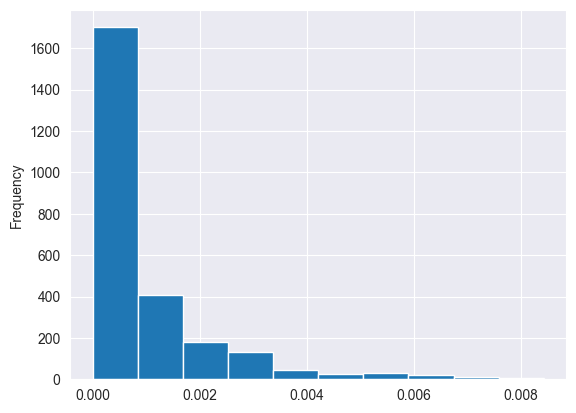

In [156]:
#trades.profit_percent.plot(kind='hist', bins =10,)   #old
plt.show()

NameError: name 'plt' is not defined

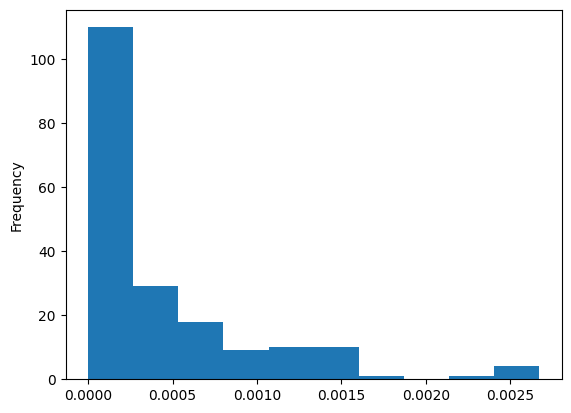

In [5]:
trades.profit_percent.plot(kind='hist', bins =10,)
plt.show()

In [157]:
#trades.profit_percent.describe()  #old

count    2.561000e+03
mean     9.289038e-04
std      1.305099e-03
min      1.720977e-07
25%      9.603340e-05
50%      3.935010e-04
75%      1.210067e-03
max      8.433223e-03
Name: profit_percent, dtype: float64

In [7]:
trades.profit_percent.describe()

count    1.920000e+02
mean     4.171550e-04
std      5.516604e-04
min      5.417187e-07
25%      2.764275e-05
50%      1.733168e-04
75%      5.698052e-04
max      2.671422e-03
Name: profit_percent, dtype: float64

In [159]:
trades.symbol.value_counts()

symbol
ETHUSDT     964
SOLUSDT     872
BTCUSDT     421
DOGEUSDT    304
Name: count, dtype: int64

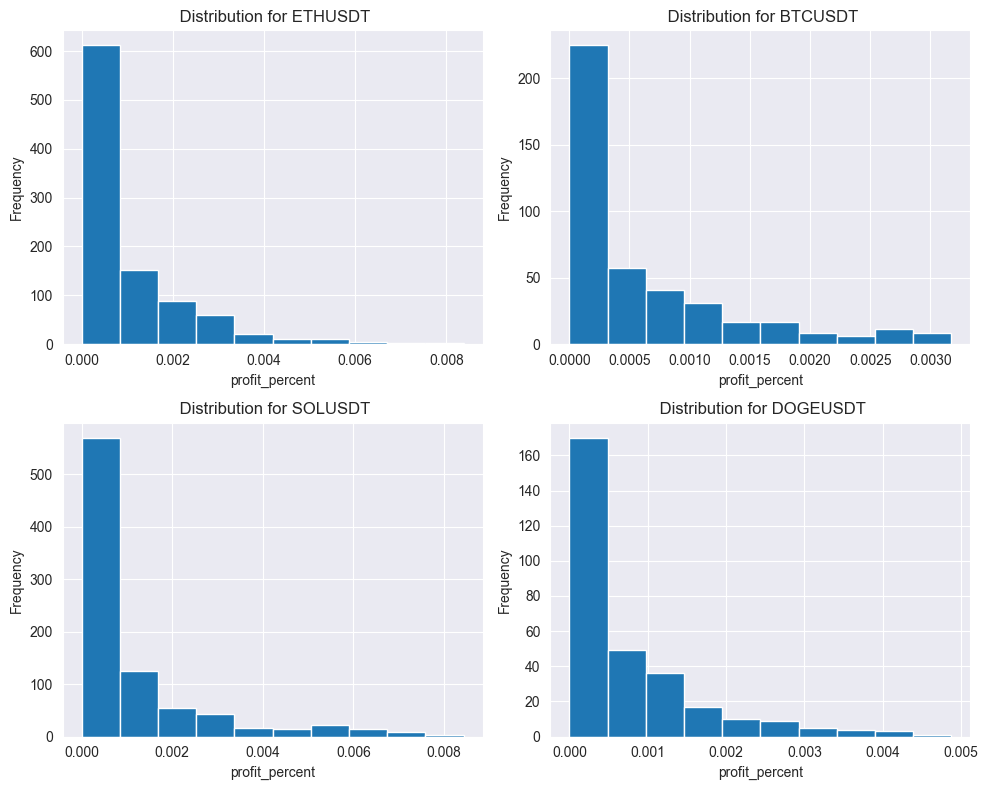

In [168]:
# Plotting the histograms for each symbol
symbols = trades['symbol'].unique()
symbols = symbols[symbols != None]


plt.figure(figsize=(10, 8))

for i, symbol in enumerate(symbols):
    plt.subplot(2, 2, i+1)
    trades[trades['symbol'] == symbol]['profit_percent'].hist(bins=10)
    plt.title(f' Distribution for {symbol}')
    plt.xlabel('profit_percent')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

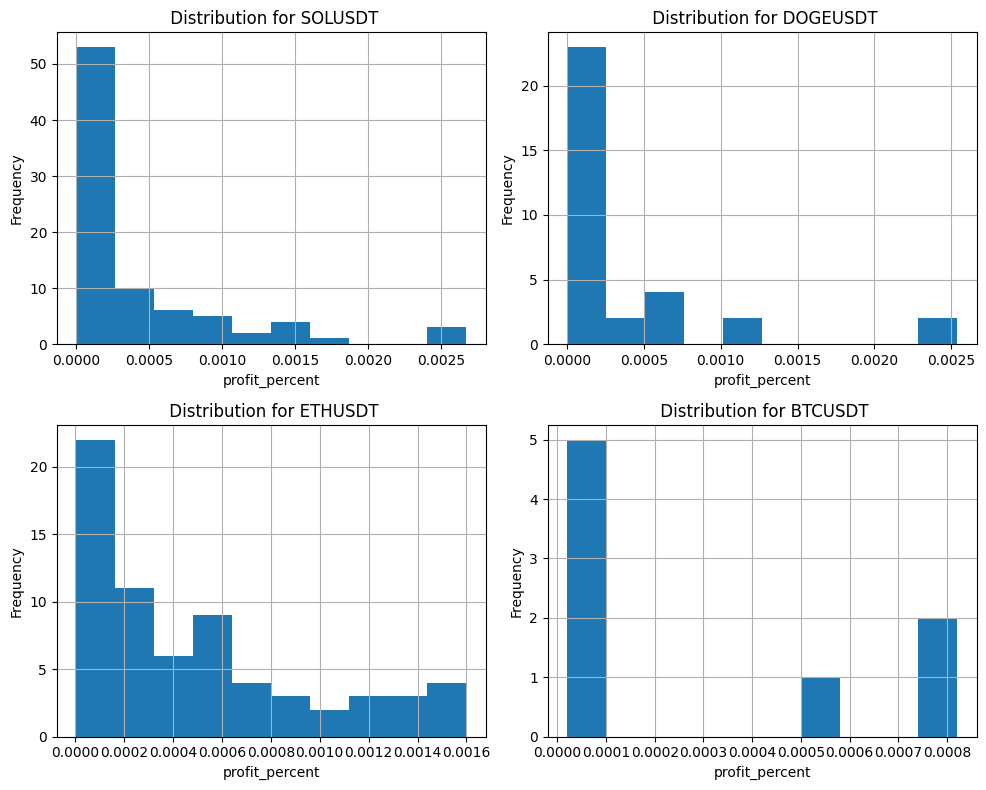

In [8]:
# Plotting the histograms for each symbol
symbols = trades['symbol'].unique()
symbols = symbols[symbols != None]


plt.figure(figsize=(10, 8))

for i, symbol in enumerate(symbols):
    plt.subplot(2, 2, i+1)
    trades[trades['symbol'] == symbol]['profit_percent'].hist(bins=10)
    plt.title(f' Distribution for {symbol}')
    plt.xlabel('profit_percent')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [169]:
df = pd.DataFrame(trades)

# Group by symbol and calculate the sum of profit_percent
total_profit = df.groupby('symbol')['profit_percent'].sum()
total_profit

symbol
BTCUSDT     0.254560
DOGEUSDT    0.224830
ETHUSDT     0.932300
SOLUSDT     0.967233
Name: profit_percent, dtype: float64

In [170]:
df = pd.DataFrame(trades)

# Group by symbol and calculate the sum of profit_percent
buy_exchange = df.groupby('buy_exchange')['profit_percent'].sum()
buy_exchange

buy_exchange
Binance    0.842419
Bybit      0.548035
Huobi      0.471815
OKX        0.516654
Name: profit_percent, dtype: float64

In [171]:
df = pd.DataFrame(trades)

# Group by symbol and calculate the sum of profit_percent
sell_exchange = df.groupby('sell_exchange')['profit_percent'].sum()
sell_exchange

sell_exchange
Binance    0.588919
Bybit      0.713657
Huobi      0.564884
OKX        0.511462
Name: profit_percent, dtype: float64

In [175]:
# Initialize a list to store individual summary DataFrames
summary_list = []

# Get unique combinations of symbols and exchanges
symbols = trades['symbol'].unique()
symbols = symbols[symbols != None]
exchanges = trades['buy_exchange'].unique()
exchanges = exchanges[exchanges != None]

for symbol in symbols:
    for exchange in exchanges:
        # Count buy trades
        num_buy_trades = trades[(trades['symbol'] == symbol) & (trades['buy_exchange'] == exchange)].shape[0]
        # Count sell trades
        num_sell_trades = trades[(trades['symbol'] == symbol) & (trades['sell_exchange'] == exchange)].shape[0]
        
        # Create a summary DataFrame for this exchange-symbol combination
        summary_df = pd.DataFrame({
            'exchange': [exchange],
            'symbol': [symbol],
            'num_buy_trades': [num_buy_trades],
            'num_sell_trades': [num_sell_trades]
        })
        
        # Append the summary DataFrame to the list
        summary_list.append(summary_df)

# Concatenate all summary DataFrames into one
final_summary_df = pd.concat(summary_list, ignore_index=True)

final_summary_df

,exchange,symbol,num_buy_trades,num_sell_trades
0,Huobi,ETHUSDT,202,267
1,OKX,ETHUSDT,231,202
2,Bybit,ETHUSDT,205,289
3,Binance,ETHUSDT,326,206
4,Huobi,BTCUSDT,89,128
5,OKX,BTCUSDT,84,89
6,Bybit,BTCUSDT,99,118
7,Binance,BTCUSDT,149,86
8,Huobi,SOLUSDT,159,232
9,OKX,SOLUSDT,184,213


In [9]:
# Initialize a list to store individual summary DataFrames
summary_list = []

# Get unique combinations of symbols and exchanges
symbols = trades['symbol'].unique()
symbols = symbols[symbols != None]
exchanges = trades['buy_exchange'].unique()
exchanges = exchanges[exchanges != None]

for symbol in symbols:
    for exchange in exchanges:
        # Count buy trades
        num_buy_trades = trades[(trades['symbol'] == symbol) & (trades['buy_exchange'] == exchange)].shape[0]
        # Count sell trades
        num_sell_trades = trades[(trades['symbol'] == symbol) & (trades['sell_exchange'] == exchange)].shape[0]
        
        # Create a summary DataFrame for this exchange-symbol combination
        summary_df = pd.DataFrame({
            'exchange': [exchange],
            'symbol': [symbol],
            'num_buy_trades': [num_buy_trades],
            'num_sell_trades': [num_sell_trades]
        })
        
        # Append the summary DataFrame to the list
        summary_list.append(summary_df)

# Concatenate all summary DataFrames into one
final_summary_df = pd.concat(summary_list, ignore_index=True)

final_summary_df

,exchange,symbol,num_buy_trades,num_sell_trades
0,Binance,SOLUSDT,61,21
1,Huobi,SOLUSDT,7,20
2,OKX,SOLUSDT,7,19
3,Bybit,SOLUSDT,9,24
4,Binance,DOGEUSDT,27,6
5,Huobi,DOGEUSDT,0,0
6,OKX,DOGEUSDT,3,12
7,Bybit,DOGEUSDT,3,15
8,Binance,ETHUSDT,37,28
9,Huobi,ETHUSDT,8,10
